In [1]:
%matplotlib inline
##############system functions#################
import os
import datetime

##############pandas###################
import pandas as pd
from pandas.api.types import is_numeric_dtype

##############numpy###################
import numpy as np

##############visualizations###################
import matplotlib.pyplot as plt


##############statsmodels####################
from statsmodels.stats.outliers_influence import variance_inflation_factor

##############sklearn##############################
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
# from sklearn.pandas import CategoricalImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#############tensorflow###################
import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

In [2]:
try:
    #Obtain current directory
    print("Current Directory:", os.getcwd())
    #Change the current working Directory    
    os.chdir("../aisData/AIS_ASCII_by_UTM_Month/2017_v2/")
    print("Directory changed.")
except OSError:
    print("Can't change the Current Working Directory.")    

Current Directory: /mnt/c/Users/18567/shipmentML/notebooks
Directory changed.


In [3]:
#Helper Functions
def frac(df, fraction, other_info=None):
    """
    Input parameter df: dataframe object.
    Input parameter fraction: float between 0 and 1.
    Output: dataframe object.
    
    Returns fraction of data.
    """
    return df.sample(frac=fraction)

def percentOfNulls(df):
    """
       Input parameter df: dataframe object.
       Output: series object.
       
       Returns percentage of nulls in each column. 
    """
    
    return df.isna().sum(axis=0)/len(df)

def removeNullsThreshold(df, threshold):
    """
       Input parameter df: dataframe object.
       Input parameter threshold: float value between 0 and 1. 
       Output: dataframe object.
       
       Removes any columns where nulls are greater than some threshold. 
    """
    colIndex = percentOfNulls(df).where(lambda val: val < threshold)\
                                 .dropna()\
                                 .index
    return df.loc[:, colIndex]

def numericData(df):
    """
       Input parameter df: dataframe object.
       Output: dataframe object.
       
       Returns only numeric columns. 
    """
    
    booleanMask = df.apply(lambda series: is_numeric_dtype(series) , result_type='expand')
    return df.loc[:, booleanMask]
    

def percentOfNegatives(df):
    """
       Input parameter df: dataframe object.
       Output: series object.
       
       Returns percentage of negatives in each column. 
    """
    return (numericData(df) < 0).sum(axis=0)/len(df)
    
def sparseData(df):
    """
       Input parameter df: dataframe object.
       Output: series object.
       
       Returns percentage of zeroes in each column. 
    """
    
    return ((df == 0).sum(axis=0))/len(df)


def filterData(df, colName, count):
    """
       Input parameter df: dataframe object.
       Input parameter colName: string.
       Input parameter count: integer value. 
       Output: dataframe object.
       
       Returns subsetted data by grouping on a column and removes any group with fewer records than the count.  
    """
    groups = df[colName].value_counts()\
                     .where(lambda val: val > count)\
                     .dropna()\
                     .index
    
    result = df.loc[df[colName].isin(groups)]
    return result 

def calculateVif(df,  labelName, threshold=0.5, excludeNa=True):
    """
       Input parameter df: dataframe object.
       Input parameter labelName: string.
       Input parameter threshold: integer value. 
       Input parameter excludeNa: boolean
       Output: series object.
       
       Calculates variance inflactor factor for each numeric column in dataframe. Values above 5 are said to be colinear.  
    """
    X = df.drop(labelName, axis = 1)\
          .assign(const=1)
    X = numericData(X)
    if excludeNa:
        X = X.dropna()
    assert any(percentOfNulls(X).apply(lambda val: val > 0)) != True, "Data contains nulls."
    result = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    return result

In [4]:
#Read in the data
jan2017Data = pd.read_csv('AIS_2017_01_Zone10.csv')

In [5]:
#Subset data for faster computation (not randomly done)
jan2017Data = jan2017Data.iloc[:1000000]

#Subset data for faster computation (randomly done) #Don't use this technique if preprocessing
# jan2017Data = frac(jan2017Data, 0.05)

# Exploratory Data Analysis (will add more)

In [6]:
#Snippet of data 
jan2017Data.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,367114690,2017-01-01T00:00:06,48.51094,-122.60705,0.0,-49.6,511.0,NaN,NaN,NaN,NaN,under way using engine,NaN,NaN,NaN,NaN
1,367479990,2017-01-01T00:00:03,48.15891,-122.67268,0.1,10.1,353.0,WSF KENNEWICK,IMO9618331,WDF6991,1012.0,moored,83.39,19.5,3.2,NaN
2,368319000,2017-01-01T00:00:08,43.34576,-124.32142,0.0,32.8,173.0,NaN,NaN,NaN,NaN,engaged in fishing,NaN,NaN,NaN,NaN
3,367154100,2017-01-01T00:00:15,46.74264,-124.93125,6.8,6.0,352.0,NaN,NaN,NaN,NaN,undefined,NaN,NaN,NaN,NaN
4,367446870,2017-01-01T00:00:59,48.51320,-122.60718,0.0,23.2,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Size of data 
jan2017Data.shape

(1000000, 16)

In [8]:
#Check types of columns
jan2017Data.dtypes

MMSI              int64
BaseDateTime     object
LAT             float64
LON             float64
SOG             float64
COG             float64
Heading         float64
VesselName       object
IMO              object
CallSign         object
VesselType      float64
Status           object
Length          float64
Width           float64
Draft           float64
Cargo           float64
dtype: object

In [9]:
#Obtain number of ships 
print("The number of unique ships in the data is {}.".format(len(jan2017Data['MMSI'].unique())))

The number of unique ships in the data is 1763.


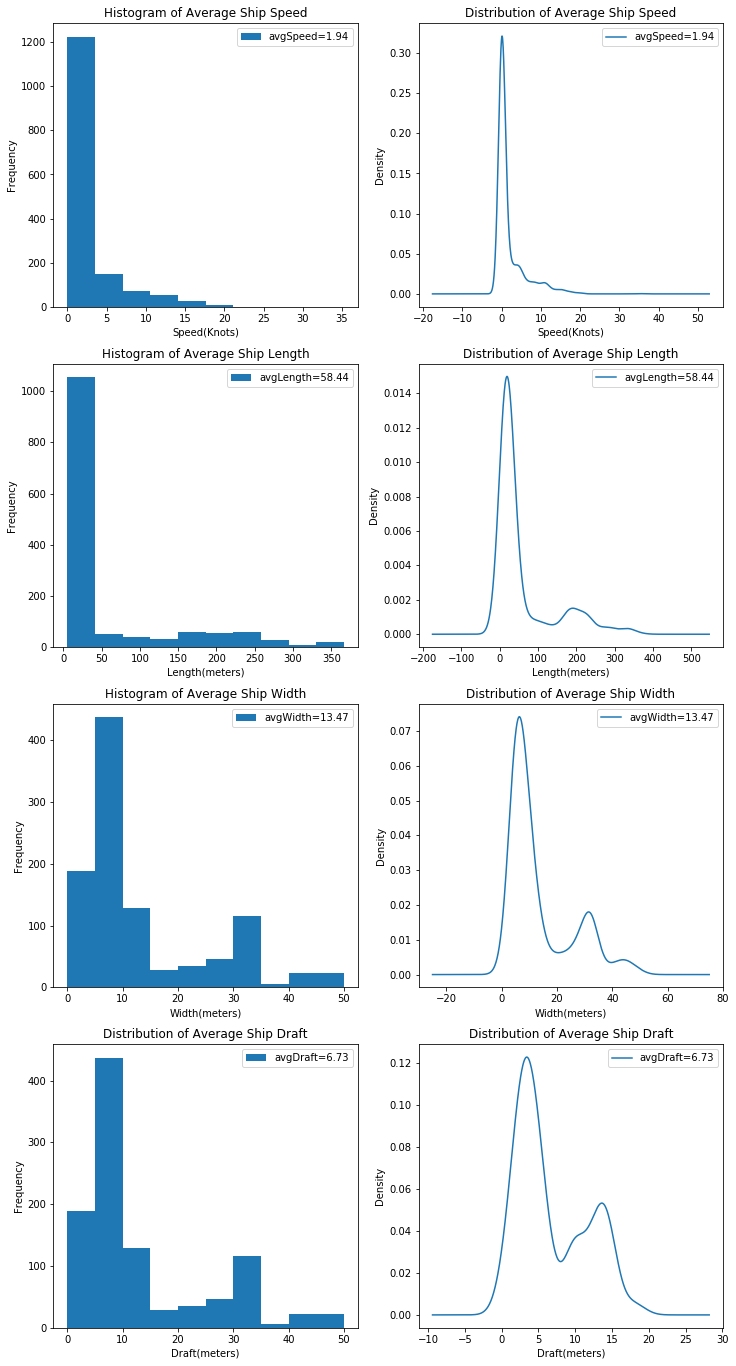

In [10]:
#Speed & Width & Length Distribution Plots 
#There are speeds that are below 0 as well as NA's. Consider when preprocessing.
#There are lengths that are NA. Consider when preprocessing.
#There are widths that are NA. Consider when preprocessing. 

avgSpeedPerShip = jan2017Data.groupby('MMSI')\
                             .mean()['SOG']\
                             .where(lambda val: val > 0)
avgLengthPerShip = jan2017Data.groupby('MMSI')\
                              .mean()['Length']
avgWidthPerShip = jan2017Data.groupby('MMSI')\
                             .mean()['Width']
avgDraftPerShip = jan2017Data.groupby('MMSI')\
                             .mean()['Draft']

plt.figure(num=1, figsize=(12, 24))

plt.subplot(421)
ax1 = avgSpeedPerShip.plot(kind='hist', title='Histogram of Average Ship Speed', label='avgSpeed={:.2f}'.format(avgSpeedPerShip.mean()))
ax1.legend()
ax1.set_xlabel('Speed(Knots)')

plt.subplot(422)
ax2 = avgSpeedPerShip.plot(kind='density', title='Distribution of Average Ship Speed', label='avgSpeed={:.2f}'.format(avgSpeedPerShip.mean()))
ax2.set_xlabel('Speed(Knots)')
ax2.legend()

plt.subplot(423)
ax3 = avgLengthPerShip.plot(kind='hist', title='Histogram of Average Ship Length', label='avgLength={:.2f}'.format(avgLengthPerShip.mean()))
ax3.legend()
ax3.set_xlabel('Length(meters)')

plt.subplot(424)
ax4 = avgLengthPerShip.plot(kind='density', title='Distribution of Average Ship Length', label='avgLength={:.2f}'.format(avgLengthPerShip.mean()))
ax4.set_xlabel('Length(meters)')
ax4.legend()


plt.subplot(425)
ax5 = avgWidthPerShip.plot(kind='hist', title='Histogram of Average Ship Width', label='avgWidth={:.2f}'.format(avgWidthPerShip.mean()))
ax5.legend()
ax5.set_xlabel('Width(meters)')

plt.subplot(426)
ax6 = avgWidthPerShip.plot(kind='density', title='Distribution of Average Ship Width', label='avgWidth={:.2f}'.format(avgWidthPerShip.mean()))
ax6.set_xlabel('Width(meters)')
ax6.legend()

plt.subplot(427)
ax6 = avgWidthPerShip.plot(kind='hist', title='Distribution of Average Ship Draft', label='avgDraft={:.2f}'.format(avgDraftPerShip.mean()))
ax6.set_xlabel('Draft(meters)')
ax6.legend()

plt.subplot(428)
ax6 = avgDraftPerShip.plot(kind='density', title='Distribution of Average Ship Draft', label='avgDraft={:.2f}'.format(avgDraftPerShip.mean()))
ax6.set_xlabel('Draft(meters)')
ax6.legend()
plt.show()

# Data Preprocessing (will add more)

In [11]:
#Change a column to datetime
jan2017Data['BaseDateTime'] = pd.to_datetime(jan2017Data['BaseDateTime'])

In [12]:
#Obtain the time differences for each ship & create new time column which follows index order & create labels
aggDf = jan2017Data.groupby('MMSI', sort=False)\
                   .apply(lambda df: df.sort_values(by='BaseDateTime'))
timeDiff = aggDf.groupby(level=0, sort=False)\
                .apply(lambda df: df['BaseDateTime'].diff())\
                .reset_index(level=[0,1], drop=True)

jan2017Data['timeDiff'] = timeDiff

jan2017Data['labels'] = jan2017Data['timeDiff'].apply(lambda val:1 if val > datetime.timedelta(minutes=2) else 0)

In [13]:
#Percentage of Negatives in the Data #Check for any outliers 
percentOfNegatives(jan2017Data)

MMSI          0.000000
LAT           0.000000
LON           1.000000
SOG           0.003263
COG           0.542493
Heading       0.000000
VesselType    0.000000
Length        0.000000
Width         0.000000
Draft         0.000000
Cargo         0.000000
labels        0.000000
dtype: float64

In [14]:
#Percentage of Nulls in the Data #Remove columns with nulls greater than 0.8
print(percentOfNulls(jan2017Data))
jan2017Data = removeNullsThreshold(jan2017Data, 0.6)

MMSI            0.000000
BaseDateTime    0.000000
LAT             0.000000
LON             0.000000
SOG             0.000000
COG             0.000000
Heading         0.000000
VesselName      0.044306
IMO             0.522415
CallSign        0.193714
VesselType      0.111413
Status          0.306071
Length          0.145443
Width           0.295900
Draft           0.584314
Cargo           0.637563
timeDiff        0.001763
labels          0.000000
dtype: float64


In [15]:
#Write code to check for duplicates & remove them

In [16]:
#Remove ships with less than 10 records #Will need to change labeledData back to jan2017Data for entire notebook to flow
labeledData = filterData(jan2017Data, 'MMSI', 10)

In [17]:
#Checking multicollinearity of features #Write code that removes multicollinear features 
calculateVif(labeledData, 'labels')

/home/karan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


MMSI           1.154859
LAT            1.525695
LON            1.220996
SOG            1.452918
COG            1.043254
Heading        1.326780
VesselType     1.104800
Length        20.046186
Width         18.421015
Draft          6.578384
const          0.000000
dtype: float64

In [18]:
#Check class imbalance #Write code that resolves class imbalance if there is any
labeledData['labels'].value_counts()

0    533182
1    466555
Name: labels, dtype: int64

In [19]:
#Remove time columns and primary key identifiers #Remove MMSI after splitting data #Keep time component if using Recurrent Neural Network
#Feature engineer lat and Lon because right now they don't represent anything.
labeledData = labeledData.drop(['BaseDateTime', 'timeDiff', 'IMO', 'LAT','LON'], axis=1)

In [20]:
#Distinguish the features
numericFeatures = ['SOG', 'COG', 'Heading', 'Length','Width','Draft']
categoricalFeatures = ['VesselName', 'CallSign', 'VesselType','Status']

In [21]:
#Fill na's of categorical features with -1 #Needed for one-hot encoding
labeledData = labeledData.fillna({ 
                                    (colNames):('nan' if colNames in categoricalFeatures 
                                    else np.nan) for colNames in labeledData.columns 
                                 })
#Create all values in VesselType to be the same #Needed for one-hot encoding
labeledData['VesselType'] = labeledData['VesselType'].apply(lambda val: str(val))

In [22]:
#Divide the data into train and validation sets
X = labeledData.loc[:, labeledData.columns != 'labels']
y = labeledData.loc[:,'labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [23]:
#Store MMSI
trainShips = X_train.pop('MMSI')
testShips = X_test.pop('MMSI')

In [28]:
#Impute numeric columns and scale based on gaussian with mean = 0 and std.dev of 1
#One Hot Encode categorical features and drop a feature to reduce multicollinearity
numericTransformer = Pipeline(steps=[
                            ('simpImputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                    ])

categoricalTransformer = Pipeline(steps=[
                            ('onehot', OneHotEncoder(drop='first'))
                    ])

preprocessor = ColumnTransformer(transformers=[
                        ('num', numericTransformer, numericFeatures),
                        ('cat', categoricalTransformer, categoricalFeatures)
                    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', LogisticRegression(solver='lbfgs'))])

In [32]:
oneRow = X_train.toarray()[0]

In [33]:
oneRow.shape

(2867,)

In [ ]:
with f as f.write

# Modelling

In [ ]:
%%time
tf.random.set_seed(1)

model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.tanh, name='fc1', input_shape=(2867, )),
    keras.layers.Dense(1, activation=tf.nn.sigmoid, name='fc2')
])


model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()


numEpochs = 100
trainingSize = 699815
batchSize = 7
stepsPerEpoch = np.ceil(trainingSize/batchSize)
dsTrainOrig = tf.data.Dataset.from_tensor_slices(
                                                 (tf.cast(X_train.toarray(), tf.float32), 
                                                  tf.cast(y_train, tf.float32))
                                                )

dsTrain = dsTrainOrig.shuffle(buffer_size=trainingSize)
dsTrain = dsTrain.repeat()
dsTrain = dsTrain.batch(batch_size=batchSize)
dsTrain = dsTrain.prefetch(buffer_size=1000)

history = model.fit(dsTrain, epochs=numEpochs, steps_per_epoch=stepsPerEpoch, verbose=0)

# scores = model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

history.model.save('trialModel.h5',
                overwrite=True,
                include_optimizer=True,
                save_format='h5')